# Download Whole History of Stock as Base

In [1]:
import yfinance as yf

df = yf.download("SPY", period="max")
df.to_pickle('stock_max.data')
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-04,377.000000,378.869995,370.000000,376.350006,376.350006,103449600
2022-11-07,377.709991,380.570007,375.529999,379.950012,379.950012,68286900
2022-11-08,381.109985,385.119995,377.720001,382.000000,382.000000,84641100
2022-11-09,379.929993,381.140015,373.609985,374.130005,374.130005,78495500
2022-11-10,388.049988,395.040009,385.640015,394.690002,394.690002,141195500


# Merge Base with Most Recent Data, and Serialise It

In [2]:
import pandas as pd
import yfinance as yf

# base dataset from local (max)
db = pd.read_pickle('stock_max.data') 

# recent dataset (1y)
ds = yf.download("SPY", period="1y")

# dataset missing (+1y, -max)
ds.index.difference(db.index)
idx1 = ds.index
idx2 = db.index
dd = ds.loc[idx1.difference(idx2)]

# complete dataset (max+ (+1y, -max))
df = pd.concat([db, dd], axis=0)
df.to_pickle('stock_all.data')
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-04,377.000000,378.869995,370.000000,376.350006,376.350006,103449600
2022-11-07,377.709991,380.570007,375.529999,379.950012,379.950012,68286900
2022-11-08,381.109985,385.119995,377.720001,382.000000,382.000000,84641100
2022-11-09,379.929993,381.140015,373.609985,374.130005,374.130005,78495500
2022-11-10,388.049988,395.040009,385.640015,394.690002,394.690002,141195500


# Extract features (X), and calculate stock price changes (Y)

In [4]:
import pandas as pd

df = pd.read_pickle('stock_all.data') 

# using previous day's value if missing
df.ffill(inplace=True) 

# Candlestick: Body and Wicks (Tails)
df['CloseOpen'] = df['Close']/df['Open']
df['CloseLow'] = df['Close']/df['Low']
df['CloseHigh'] = df['Close']/df['High']
df['CloseBack'] = df['Close']/df['Close'].shift(1)
df.fillna(1.0, inplace=True)

df['CloseF'] = df['Close'].shift(-1)/df['Close']

df[['Close','CloseOpen','CloseLow','CloseHigh','CloseBack','CloseF']].tail()

,Close,CloseOpen,CloseLow,CloseHigh,CloseBack,CloseF
Date,,,,,,
2022-11-04,376.350006,0.998276,1.017162,0.993349,1.014393,1.009566
2022-11-07,379.950012,1.005931,1.011770,0.998371,1.009566,1.005395
2022-11-08,382.000000,1.002335,1.011331,0.991899,1.005395,0.979398
2022-11-09,374.130005,0.984734,1.001392,0.981608,0.979398,1.054954
2022-11-10,394.690002,1.017111,1.023467,0.999114,1.054954,NaN


# Visualize Most Recent Stock Daily Price Changes

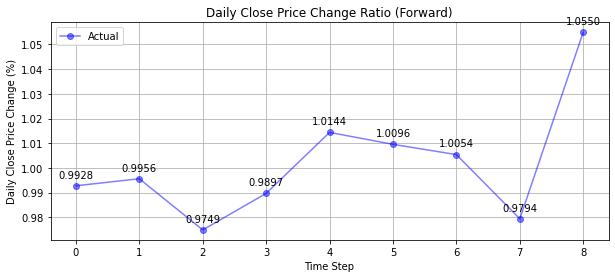

In [5]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))

plt.title("Daily Close Price Change Ratio (Forward)")
plt.xlabel("Time Step")
plt.ylabel("Daily Close Price Change (%)")

plt.grid(True)

d = 10
xs = np.arange(0,d,1)
y = df['CloseF'].to_numpy()
ys = y[y.shape[0]-d:y.shape[0]]

plt.plot(xs,ys,'bo-',alpha=0.5, label = 'Actual')

# zip joins x and y coordinates in pairs
for x,y in zip(xs,ys):
    label = "{:.4f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,8), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.legend()    
plt.show()

# Create Datasets for Training and Testing

In [7]:
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# ensure results reproducible
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# data sets for inputs and outputs
x = df[['CloseOpen','CloseLow','CloseHigh','CloseBack']].to_numpy()
y = df[['CloseF']].to_numpy()

# split whole set into train and test
trainX, testX = np.split(x, [int(len(x)*0.9)])
trainY, testY = np.split(y, [int(len(y)*0.9)])

# normalize inputs
scaler = MinMaxScaler(feature_range=(0, 1))
trainX = scaler.fit_transform(trainX)
testX = scaler.fit_transform(testX)

# LSTM Input Shape: 3D tensor with 
# shape (batch_size, timesteps, input_dim)
# reshape data to extend dimension
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

trainX.shape

(6751, 1, 4)

# Create Keras-LSTM Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(2, input_shape=(1, 4)))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2)                 56        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________


# Train LSTM Model

In [9]:
model.compile(
    loss='mse',
    optimizer='adam') 

hist = model.fit(
    trainX, 
    trainY, 
    validation_split = 0.2, 
    epochs=40, 
    batch_size=5, 
    verbose=1)

# model.save('price_change_ratio.h5')

Epoch 1/40
1080/1080 [==============================] - 7s 4ms/step - loss: 0.0990 - val_loss: 9.2360e-04
Epoch 2/40
1080/1080 [==============================] - 4s 4ms/step - loss: 0.0018 - val_loss: 7.0110e-04
Epoch 3/40
1080/1080 [==============================] - 4s 3ms/step - loss: 0.0013 - val_loss: 4.8652e-04
Epoch 4/40
1080/1080 [==============================] - 4s 4ms/step - loss: 9.3366e-04 - val_loss: 4.0527e-04
Epoch 5/40
1080/1080 [==============================] - 4s 4ms/step - loss: 6.5198e-04 - val_loss: 2.3388e-04
Epoch 6/40
1080/1080 [==============================] - 4s 3ms/step - loss: 4.4057e-04 - val_loss: 1.4942e-04
Epoch 7/40
1080/1080 [==============================] - 4s 3ms/step - loss: 2.9711e-04 - val_loss: 1.1510e-04
Epoch 8/40
1080/1080 [==============================] - 4s 3ms/step - loss: 2.1196e-04 - val_loss: 9.5582e-05
Epoch 9/40
1080/1080 [==============================] - 4s 3ms/step - loss: 1.7243e-04 - val_loss: 8.4217e-05
Epoch 10/40
1080/1080 

# Visualize Training Loss and Validation Loss

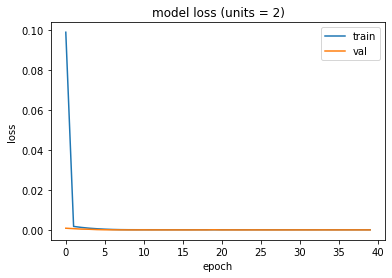

In [10]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss (units = 2)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Visualize the Predicted and Actual Stock Daily Price Changes

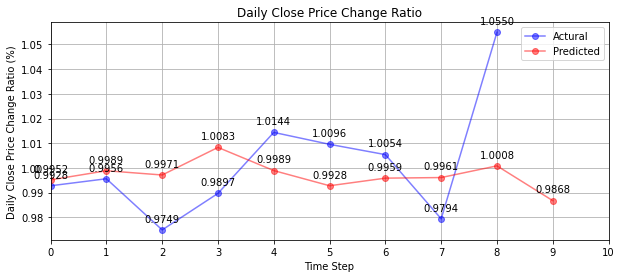

In [11]:
from keras.models import load_model
from matplotlib.ticker import MultipleLocator

# model = load_model('price_change_ratio.h5')

fig, ax = plt.subplots(figsize=(10, 4))

plt.title("Daily Close Price Change Ratio")
plt.xlabel("Time Step")
plt.ylabel("Daily Close Price Change Ratio (%)")

d = 10
ax.set_xlim(0,d)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.01))

xs = np.arange(0,d,1)
y1 = testY.transpose()
ys1 = y1[0][y1.size-d:y1.size]

y2 = model.predict(testX).transpose()
ys2 = y2[0][y2.size-d:y2.size]

plt.plot(xs,ys1.transpose(),'bo-',alpha=0.5,label='Actural')
plt.plot(xs,ys2,'ro-',alpha=0.5,label='Predicted')

# zip joins x and y coordinates in pairs
for x,y in zip(xs,ys1):
    label = "{:.4f}".format(y)
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,8),
                 ha='center')

for x,y in zip(xs,ys2):
    label = "{:.4f}".format(y)
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,8),
                 ha='center')

plt.legend()
plt.grid(True)
plt.show()